In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# Branching

- 병렬 노드 실행을 위한 분기 생성 및 처리 
    - 노드의 병렬 실행은 전체 그래프 작업 속도 향상에 필수적임 

- 병렬화는 fan-out & fan-in 매커니즘 통해 구현 
    - Fan-out, 확장
        - 큰 작업을 여러 작은 작업으로 나눔  
        - (eg) 피자를 만들 때 도우, 소스, 치즈 준비를 각각의 파트를 나눠 동시에 처리

    - Fan-in, 수집
        - 나뉜 작은 작업들을 다시 하나로 합침 
        - 여러 작업이 끝나면 결과를 모아 최종 작업을 완성하는 것 
        - (eg) 피자에 준비된 재료들을 모두 올려 완성 피자를 만드는 과정 

In [3]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [4]:
# STATE
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# GRAPH 
builder = StateGraph(State)

# 노드 A부터 D까지 생성 및 값 할당
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

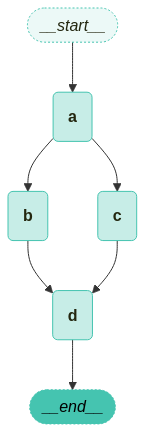

In [5]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [ ]:
# 그래프 실행
graph.invoke(
    {"aggregate": []}, 
    {"configurable": {"thread_id": "foo"}}
)

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8126ceca-d869-4c60-b9c2-eb75d2b3af0e')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8126ceca-d869-4c60-b9c2-eb75d2b3af0e')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8126ceca-d869-4c60-b9c2-eb75d2b3af0e'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f8887531-59bb-4f6b-b30a-2a261eff4640'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='d98fc9bc-fc47-4056-902d-2da11020878d')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8126ceca-d869-4c60-b9c2-eb75d2b3af0e'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f8887531-59bb-4f6b-b30a-2a261eff4640'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='d98fc9bc-fc47-4056-902d-2da11020878d'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='d1fe618e-d2a6-4b54-83e8-2b8c79e3bf1f')]}

# 예외처리 대응 

- LangGraph는 superstep 내에서 노드 실행: 여러 노드들이 처리되는 전체 프로세스 스텝
- 이는 병렬 분기가 동시에 실행되더라도 전체 superstep이 **트랜잭션** 방식으로 처리됨을 의미
- 이러한 분기 중 하나라도 예외가 발생하면, 상태에 대한 업데이트가 **전혀** 적용되지 않음 => 전체 superstep이 오류 처리됨


오류가 발생하기 쉬운 작업(예: 불안정한 API 호출 처리)이 있는 경우...

1. 노드 내에서 일반적인 Python 코드를 작성하여 예외를 포착하고 처리
2. retry_policy
    - 특정 유형의 예외가 발생한 노드를 재시도 하도록 그래프를 지시
    - 실패한 분기만 재시도 
    - https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy

In [7]:
# STATE
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# GRAPH
builder = StateGraph(State)

# 노드 생성 및 연결
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# COMPILE
graph = builder.compile()

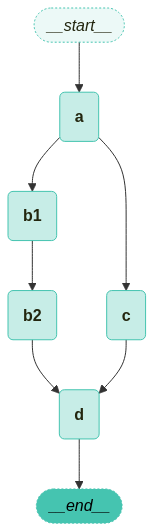

In [8]:
visualize_graph(graph)

In [9]:
# 빈 리스트를 사용한 그래프 집계 연산 실행, 모든 데이터에 대한 기본 집계 수행
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='d010c95c-3050-4b4e-8bfa-d51b9756f45f')]
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='d010c95c-3050-4b4e-8bfa-d51b9756f45f')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='d010c95c-3050-4b4e-8bfa-d51b9756f45f'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='f0ec323e-36d3-4bdb-b2c9-11fd7e68acf9'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='8cd806f4-8e25-4f5e-97d8-88c9ca850890')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='d010c95c-3050-4b4e-8bfa-d51b9756f45f'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='f0ec323e-36d3-4bdb-b2c9-11fd7e68acf9'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='8cd80

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='d010c95c-3050-4b4e-8bfa-d51b9756f45f'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='f0ec323e-36d3-4bdb-b2c9-11fd7e68acf9'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='8cd806f4-8e25-4f5e-97d8-88c9ca850890'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='98eb5a58-30af-439b-bcf0-6ddc9f1c840c'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='d62bef70-3961-4569-929c-feb424a88aba')]}

# Conditional Branching

In [10]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph

In [11]:
# STATE
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# 노드별 고유 값을 반환하는 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# GRAPH
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# 상태의 'which' 값에 따른 조건부 라우팅 경로 결정 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 전체 병렬 처리할 노드 목록
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


# COMPILE
builder.add_edge("e", END)
graph = builder.compile()

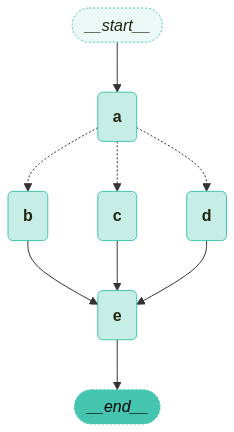

In [12]:
visualize_graph(graph)

In [13]:
# 그래프 실행(which: HERE 로 지정)
graph.invoke({"aggregate": [], "which": "HERE"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='a79ce47d-a1b2-4c91-abaa-5e8720d60a42')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='a79ce47d-a1b2-4c91-abaa-5e8720d60a42')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='a79ce47d-a1b2-4c91-abaa-5e8720d60a42'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='9f392098-c3bf-4d77-9cf6-a6a1818dc767'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2abb07a9-867f-4a8d-a782-63b33fc80a80')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='a79ce47d-a1b2-4c91-abaa-5e8720d60a42'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='9f392098-c3bf-4d77-9cf6-a6a1818dc767'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2abb07a9-867f-4a8d-a782-63b33fc80a80'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='85ffc6fb-4df4-4708-8fc6-1a724e6d6227')],
 'which': 'HERE'}

-----
** End of Documents **